# Dynamic Volatility Surface & Options Strategy Simulator

## Comprehensive Demonstration Notebook

This notebook demonstrates a complete end-to-end workflow for:
1. **Fetching option chain data** from yfinance
2. **Calculating implied volatility** using Black-Scholes
3. **Building volatility surfaces** with multiple interpolation methods
4. **Visualizing** 2D smiles, term structure, and 3D surfaces
5. **Calculating Greeks** (Delta, Gamma, Vega, Theta, Rho)
6. **Implementing trading strategies** (Volatility Arbitrage & Gamma Scalping)
7. **Backtesting** with comprehensive performance metrics
8. **P&L attribution** analysis

---

**Author**: Raghav Jha  
**Date**: November 2025  
**Ticker**: SPY (S&P 500 ETF)

## 1. Setup & Imports

First, let's import all necessary libraries and set up our environment.

In [1]:
# Install required packages (uncomment if needed)
%pip install numpy pandas scipy matplotlib seaborn plotly yfinance numba pyyaml python-dotenv

You should consider upgrading via the '/Volumes/External/Volatility-Surface-Options-Strategy/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Volumes/External/Volatility-Surface-Options-Strategy/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard library imports
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('..')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Our custom modules
from src.data import OptionDataFetcher, HistoricalVolatilityCalculator
from src.pricing import (
    black_scholes_call, black_scholes_put,
    ImpliedVolatilitySolver, calculate_implied_volatility_vectorized
)
from src.greeks import GreeksCalculator, calculate_greeks_dataframe
from src.surface import VolatilitySurface
from src.strategies import VolatilityArbitrageStrategy, GammaScalpingStrategy, DeltaHedger
from src.backtest import OptionsBacktester, PerformanceMetrics, generate_performance_report
from src.visualization import VolatilityVisualizer, StrategyVisualizer
from src.utils import format_percentage, format_currency

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8-darkgrid')

print("All imports successful!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All imports successful!
Analysis Date: 2025-11-28 22:07:09


## 2. Fetch Option Chain Data

Let's fetch real-time option chain data for SPY using yfinance.

In [3]:
# Initialize data fetcher
fetcher = OptionDataFetcher(cache_enabled=True, provider='yfinance')

# Fetch SPY option chain
print("Fetching SPY option chain...")
spy_chain = fetcher.get_option_chain("SPY")

# Get spot price and other data
spot_price = fetcher.get_spot_price("SPY")
risk_free_rate = fetcher.get_risk_free_rate()
dividend_yield = fetcher.get_dividend_yield("SPY")

print(f"\nFetched {len(spy_chain):,} option contracts")
print(f"SPY Spot Price: ${spot_price:.2f}")
print(f"Risk-Free Rate: {risk_free_rate:.2%}")
print(f"Dividend Yield: {dividend_yield:.2%}")
print(f"\nSample data:")
spy_chain.head(10)

Fetching SPY option chain...

Fetched 8,144 option contracts
SPY Spot Price: $682.64
Risk-Free Rate: 4.03%
Dividend Yield: 109.00%

Sample data:

Fetched 8,144 option contracts
SPY Spot Price: $682.64
Risk-Free Rate: 4.03%
Dividend Yield: 109.00%

Sample data:


,strike,expiry,type,bid,ask,last,volume,oi,iv,mid,fetch_time
0,350.0,2025-11-28,call,331.10,333.63,324.06,6.0,3.0,6.2871e+00,332.365,2025-11-28 22:03:55.199317
1,360.0,2025-11-28,call,321.08,323.76,314.44,2.0,0.0,4.0625e+00,322.420,2025-11-28 22:03:55.199317
2,375.0,2025-11-28,call,307.33,307.45,307.49,111.0,75.0,3.4375e+00,307.390,2025-11-28 22:03:55.199317
3,390.0,2025-11-28,call,291.06,293.77,288.00,1.0,25.0,3.5469e+00,292.415,2025-11-28 22:03:55.199317
4,395.0,2025-11-28,call,276.89,279.36,270.24,50.0,29.0,1.0000e-05,278.125,2025-11-28 22:03:55.199317
5,400.0,2025-11-28,call,281.08,283.76,274.14,6.0,14.0,3.4375e+00,282.420,2025-11-28 22:03:55.199317
6,405.0,2025-11-28,call,266.91,269.38,259.53,2.0,1.0,1.0000e-05,268.145,2025-11-28 22:03:55.199317
7,410.0,2025-11-28,call,271.06,273.78,264.34,2.0,14.0,3.2813e+00,272.420,2025-11-28 22:03:55.199317
8,415.0,2025-11-28,call,267.32,267.49,250.40,1.0,298.0,3.0938e+00,267.405,2025-11-28 22:03:55.199317
9,420.0,2025-11-28,call,261.05,263.68,249.97,2.0,0.0,4.7647e+00,262.365,2025-11-28 22:03:55.199317


In [4]:
# Clean the option chain
spy_clean = fetcher.clean_option_chain(
    spy_chain,
    min_volume=50,
    min_oi=100,
    max_bid_ask_spread=0.3
)

print(f"After cleaning: {len(spy_clean):,} contracts ({len(spy_clean)/len(spy_chain):.1%} retained)")
print(f"\nExpiration dates available:")
expirations = sorted(spy_clean['expiry'].unique())
for i, exp in enumerate(expirations[:5], 1):
    days_to_exp = (exp - pd.Timestamp.now()).days
    print(f"  {i}. {exp.strftime('%Y-%m-%d')} ({days_to_exp} days)")
    
spy_clean.head()

After cleaning: 706 contracts (8.7% retained)

Expiration dates available:
  1. 2025-11-28 (-1 days)
  2. 2025-12-01 (2 days)
  3. 2025-12-02 (3 days)
  4. 2025-12-03 (4 days)
  5. 2025-12-04 (5 days)


,strike,expiry,type,bid,ask,last,volume,oi,iv,mid,fetch_time
0,500.0,2025-11-28,call,182.27,182.47,181.24,284.0,233.0,2.2539e+00,182.370,2025-11-28 22:03:55.199317
1,559.0,2025-11-28,call,123.34,123.50,122.61,200.0,108.0,1.3828e+00,123.420,2025-11-28 22:03:55.199317
2,571.0,2025-11-28,call,102.56,103.93,94.68,210.0,111.0,1.0000e-05,103.245,2025-11-28 22:03:55.199317
3,625.0,2025-11-28,call,57.41,57.52,57.20,109.0,517.0,7.2266e-01,57.465,2025-11-28 22:03:55.199317
4,635.0,2025-11-28,call,47.36,47.52,46.50,105.0,1501.0,5.8008e-01,47.440,2025-11-28 22:03:55.199317


## 3. Calculate Implied Volatility

Now let's calculate implied volatility for all options using our vectorized Black-Scholes solver.

In [5]:
# Calculate implied volatility
print("Calculating implied volatility...")

# First, calculate time to maturity
current_date = pd.Timestamp.now()
spy_clean['T'] = (spy_clean['expiry'] - current_date).dt.total_seconds() / (365.25 * 24 * 3600)
spy_clean = spy_clean[spy_clean['T'] > 0]  # Remove expired options

# Add spot and rate columns for IV calculation
spy_clean['spot'] = spot_price
spy_clean['r'] = risk_free_rate

# Use our vectorized IV calculator
spy_clean['iv_calculated'] = calculate_implied_volatility_vectorized(
    spy_clean,
    current_date=current_date,
    default_rate=risk_free_rate
)

# Use calculated IV or fall back to market IV
spy_clean['iv_final'] = spy_clean['iv_calculated'].fillna(spy_clean['iv'])

# Remove any NaN or invalid IVs
spy_with_iv = spy_clean.dropna(subset=['iv_final'])
spy_with_iv = spy_with_iv[spy_with_iv['iv_final'] > 0]
spy_with_iv = spy_with_iv[spy_with_iv['iv_final'] < 2.0]  # Remove unrealistic IVs > 200%

print(f"\nIV calculated for {len(spy_with_iv):,} contracts ({len(spy_with_iv)/len(spy_clean):.1%} success)")
print(f"\nIV Statistics:")
print(f"  Mean: {spy_with_iv['iv_final'].mean():.2%}")
print(f"  Median: {spy_with_iv['iv_final'].median():.2%}")
print(f"  Std Dev: {spy_with_iv['iv_final'].std():.2%}")
print(f"  Min: {spy_with_iv['iv_final'].min():.2%}")
print(f"  Max: {spy_with_iv['iv_final'].max():.2%}")

spy_with_iv.head()

Calculating implied volatility...

IV calculated for 672 contracts (100.0% success)

IV Statistics:
  Mean: 21.93%
  Median: 16.30%
  Std Dev: 14.50%
  Min: 0.00%
  Max: 182.08%

IV calculated for 672 contracts (100.0% success)

IV Statistics:
  Mean: 21.93%
  Median: 16.30%
  Std Dev: 14.50%
  Min: 0.00%
  Max: 182.08%


,strike,expiry,type,bid,ask,last,volume,oi,iv,mid,fetch_time,T,spot,r,iv_calculated,iv_final
34,640.0,2025-12-01,put,0.03,0.04,0.04,3122.0,3004.0,0.2500,0.035,2025-11-28 22:03:55.199317,0.0057,682.64,0.0403,0.3441,0.3441
35,644.0,2025-12-01,put,0.03,0.04,0.04,100.0,2206.0,0.2285,0.035,2025-11-28 22:03:55.199317,0.0057,682.64,0.0403,0.3145,0.3145
36,645.0,2025-12-01,put,0.03,0.04,0.03,214.0,11713.0,0.2227,0.035,2025-11-28 22:03:55.199317,0.0057,682.64,0.0403,0.3071,0.3071
37,646.0,2025-12-01,put,0.03,0.04,0.04,52.0,3037.0,0.2168,0.035,2025-11-28 22:03:55.199317,0.0057,682.64,0.0403,0.2997,0.2997
38,649.0,2025-12-01,call,33.52,33.66,18.11,102.0,392.0,0.2720,33.590,2025-11-28 22:03:55.199317,0.0057,682.64,0.0403,NaN,0.2720


## 4. Build Volatility Surface

Let's construct the volatility surface using multiple interpolation methods.

In [6]:
# Build volatility surface
print("Building volatility surface...")

# Initialize surface with cubic spline interpolation
surface = VolatilitySurface(method='cubic')

# Fit the surface
surface.fit(
    strikes=spy_with_iv['strike'].values,
    maturities=spy_with_iv['T'].values,
    implied_vols=spy_with_iv['iv'].values,
    spot=spot_price
)

print(f"Surface fitted with {len(spy_with_iv)} data points")

# Get a specific point on the surface
atm_strike = spot_price
time_to_maturity = 0.25  # 3 months
atm_iv = surface.interpolate(atm_strike, time_to_maturity)

print(f"\nATM IV (K=${atm_strike:.2f}, T=3M): {atm_iv:.2%}")

# Get volatility smile for nearest expiration
nearest_expiry = spy_with_iv['T'].min()
smile_data = spy_with_iv[spy_with_iv['T'] == nearest_expiry].sort_values('strike')
print(f"\nVolatility smile points for T={nearest_expiry:.3f}y: {len(smile_data)} contracts")

Building volatility surface...
Surface fitted with 672 data points

ATM IV (K=$682.64, T=3M): 19.65%

Volatility smile points for T=0.006y: 60 contracts

Volatility smile points for T=0.006y: 60 contracts


## 5. Visualize Volatility Surface

Let's create 2D and 3D visualizations of the volatility surface.

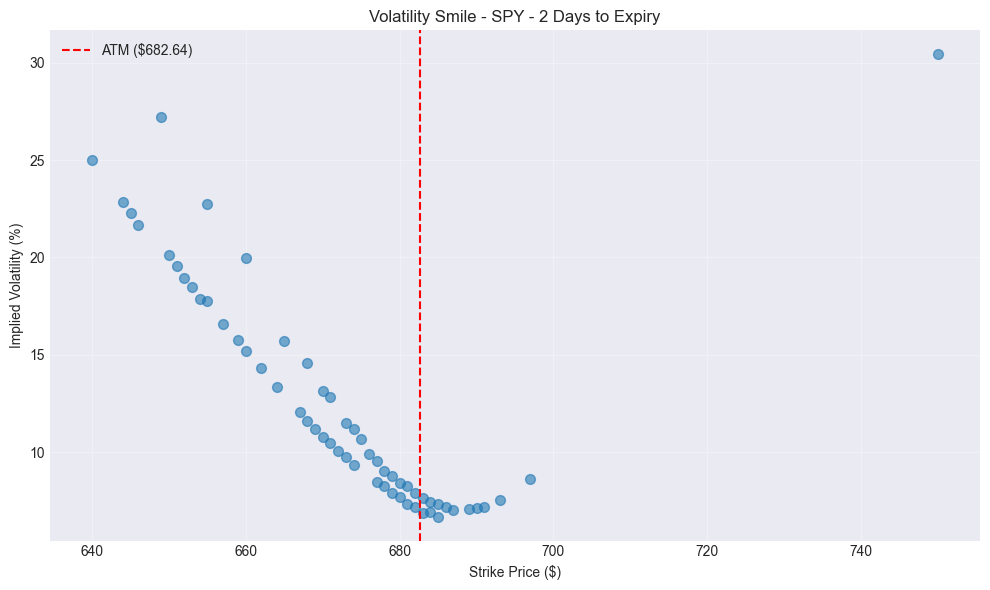

Expiry T=0.006y (2 days): 60 contracts


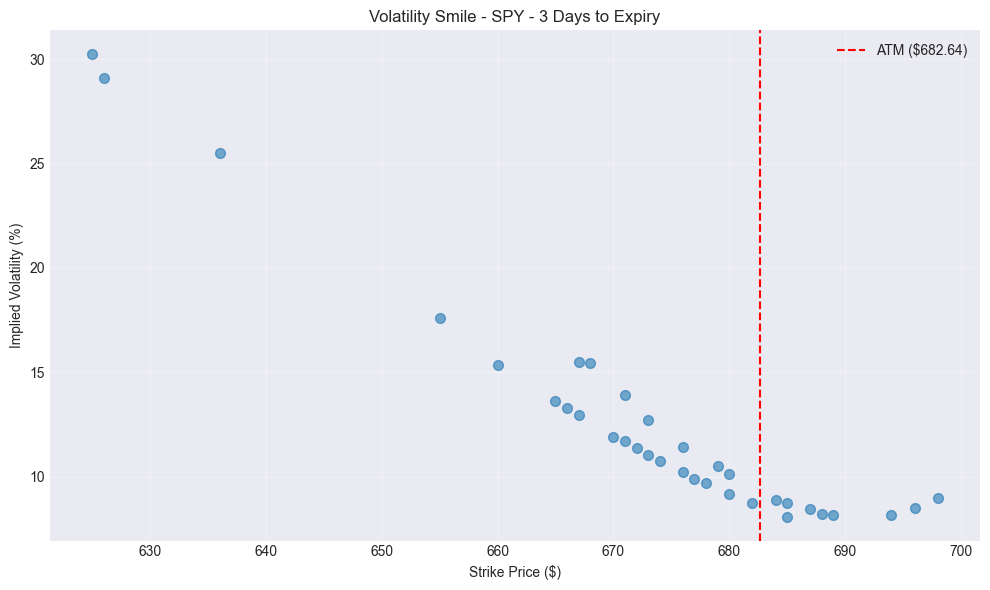

Expiry T=0.008y (3 days): 34 contracts


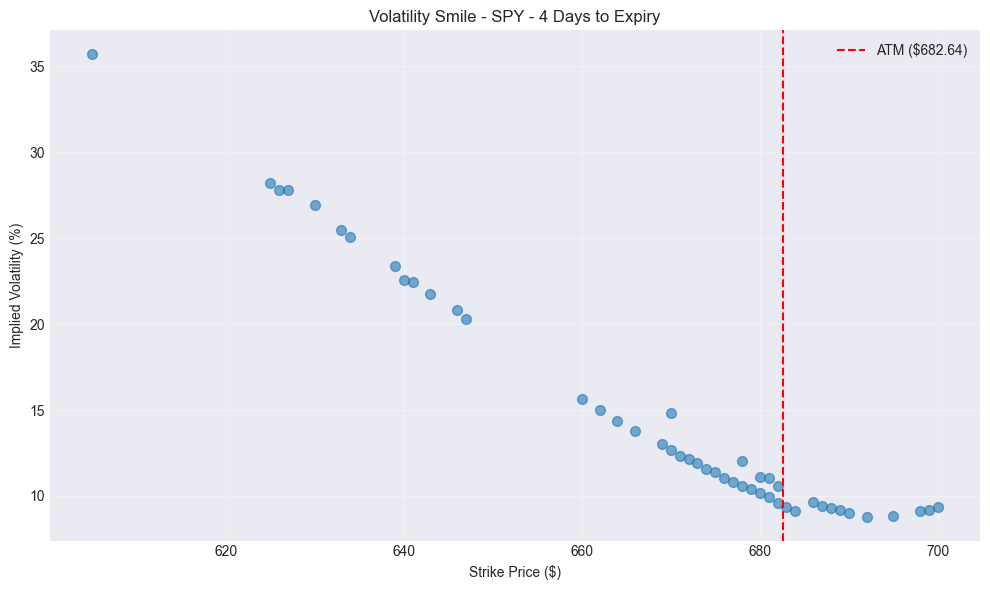

Expiry T=0.011y (4 days): 48 contracts


In [7]:
# Initialize visualizer
viz = VolatilityVisualizer(style='plotly')

# Plot 2D volatility smile for nearest expiration
expiries_to_plot = sorted(spy_with_iv['T'].unique())[:3]  # First 3 expiries

for expiry in expiries_to_plot:
    expiry_data = spy_with_iv[spy_with_iv['T'] == expiry].sort_values('strike')
    days = int(expiry * 365)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(expiry_data['strike'], expiry_data['iv'] * 100, alpha=0.6, s=50)
    plt.axvline(spot_price, color='red', linestyle='--', label=f'ATM (${spot_price:.2f})')
    plt.xlabel('Strike Price ($)')
    plt.ylabel('Implied Volatility (%)')
    plt.title(f'Volatility Smile - SPY - {days} Days to Expiry')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Expiry T={expiry:.3f}y ({days} days): {len(expiry_data)} contracts")

In [8]:
# Create 3D surface plot
K_grid, T_grid, IV_grid = surface.get_surface_grid(
    strike_range=(spot_price * 0.8, spot_price * 1.2),
    maturity_range=(0.01, 1.0),
    n_strikes=50,
    n_maturities=30
)

fig = go.Figure(data=[go.Surface(
    x=K_grid,
    y=T_grid,
    z=IV_grid * 100,
    colorscale='Viridis',
    colorbar=dict(title='IV (%)')
)])

fig.update_layout(
    title='SPY Implied Volatility Surface',
    scene=dict(
        xaxis_title='Strike Price ($)',
        yaxis_title='Time to Maturity (years)',
        zaxis_title='Implied Volatility (%)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    width=900,
    height=700
)

fig.show()

## 6. Calculate Greeks

Calculate all Greeks (Delta, Gamma, Vega, Theta, Rho) for the options.

In [ ]:
# Calculate Greeks for all options
print("Calculating Greeks...")

# Add required columns for Greeks calculation
spy_with_iv['sigma'] = spy_with_iv['iv_final']

greeks_calc = GreeksCalculator()
spy_with_greeks = calculate_greeks_dataframe(spy_with_iv)

print(f"\nGreeks calculated for {len(spy_with_greeks)} contracts")
print("\nGreeks Statistics (Calls):")
calls = spy_with_greeks[spy_with_greeks['type'] == 'call']
print(f"  Delta: Mean={calls['delta'].mean():.4f}, Std={calls['delta'].std():.4f}")
print(f"  Gamma: Mean={calls['gamma'].mean():.4f}, Std={calls['gamma'].std():.4f}")
print(f"  Vega: Mean={calls['vega'].mean():.2f}, Std={calls['vega'].std():.2f}")
print(f"  Theta: Mean={calls['theta'].mean():.4f}, Std={calls['theta'].std():.4f}")

print("\nGreeks Statistics (Puts):")
puts = spy_with_greeks[spy_with_greeks['type'] == 'put']
print(f"  Delta: Mean={puts['delta'].mean():.4f}, Std={puts['delta'].std():.4f}")
print(f"  Gamma: Mean={puts['gamma'].mean():.4f}, Std={puts['gamma'].std():.4f}")
print(f"  Vega: Mean={puts['vega'].mean():.2f}, Std={puts['vega'].std():.2f}")
print(f"  Theta: Mean={puts['theta'].mean():.4f}, Std={puts['theta'].std():.4f}")

spy_with_greeks.head()

Calculating Greeks...


TypeError: calculate_greeks_dataframe() got an unexpected keyword argument 'spot'

In [ ]:
# Visualize Greeks for ATM options
atm_options = spy_with_greeks[
    (spy_with_greeks['strike'] >= spot_price * 0.98) & 
    (spy_with_greeks['strike'] <= spot_price * 1.02)
].copy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Delta by strike
ax = axes[0, 0]
for opt_type in ['call', 'put']:
    data = atm_options[atm_options['option_type'] == opt_type]
    ax.scatter(data['strike'], data['delta'], alpha=0.6, label=opt_type.upper(), s=50)
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.axvline(spot_price, color='red', linestyle='--', alpha=0.3, label='Spot')
ax.set_xlabel('Strike')
ax.set_ylabel('Delta')
ax.set_title('Delta vs Strike (Near ATM)')
ax.legend()
ax.grid(True, alpha=0.3)

# Gamma by strike
ax = axes[0, 1]
for opt_type in ['call', 'put']:
    data = atm_options[atm_options['option_type'] == opt_type]
    ax.scatter(data['strike'], data['gamma'], alpha=0.6, label=opt_type.upper(), s=50)
ax.axvline(spot_price, color='red', linestyle='--', alpha=0.3, label='Spot')
ax.set_xlabel('Strike')
ax.set_ylabel('Gamma')
ax.set_title('Gamma vs Strike (Near ATM)')
ax.legend()
ax.grid(True, alpha=0.3)

# Vega by time to maturity
ax = axes[1, 0]
ax.scatter(spy_with_greeks['T'], spy_with_greeks['vega'], alpha=0.5, s=20)
ax.set_xlabel('Time to Maturity (years)')
ax.set_ylabel('Vega')
ax.set_title('Vega vs Time to Maturity')
ax.grid(True, alpha=0.3)

# Theta by time to maturity
ax = axes[1, 1]
ax.scatter(spy_with_greeks['T'], spy_with_greeks['theta'], alpha=0.5, s=20)
ax.set_xlabel('Time to Maturity (years)')
ax.set_ylabel('Theta')
ax.set_title('Theta vs Time to Maturity')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ATM options analyzed: {len(atm_options)}")

## 7. Trading Strategies

Implement and analyze volatility arbitrage and gamma scalping strategies.

In [ ]:
# Calculate realized volatility
print("Calculating realized volatility...")

hist_vol_calc = HistoricalVolatilityCalculator()
realized_vol = hist_vol_calc.calculate_close_to_close("SPY", window=30)

print(f"30-day realized volatility: {realized_vol:.2%}")

# Initialize volatility arbitrage strategy
vol_arb = VolatilityArbitrageStrategy(
    iv_rv_threshold=0.03,  # 3% threshold
    min_time_to_expiry=7/365,
    max_time_to_expiry=90/365
)

# Analyze each option for vol arb signals
print("\nVolatility Arbitrage Analysis:")
print(f"IV-RV Threshold: ±{vol_arb.iv_rv_threshold:.1%}")

overpriced = []
underpriced = []

for _, option in spy_with_greeks.iterrows():
    signal = vol_arb.generate_signal(
        option_data=option,
        realized_vol=realized_vol
    )
    
    if signal == 'sell_vol':
        overpriced.append(option)
    elif signal == 'buy_vol':
        underpriced.append(option)

print(f"\nOverpriced options (sell vol): {len(overpriced)}")
print(f"Underpriced options (buy vol): {len(underpriced)}")

if len(overpriced) > 0:
    print(f"\nTop 5 Overpriced Options:")
    overpriced_df = pd.DataFrame(overpriced)
    overpriced_df['iv_rv_spread'] = overpriced_df['iv'] - realized_vol
    top_overpriced = overpriced_df.nlargest(5, 'iv_rv_spread')
    print(top_overpriced[['strike', 'expiry', 'option_type', 'iv', 'iv_rv_spread']].to_string())

In [ ]:
# Gamma scalping strategy
print("Gamma Scalping Analysis:")

gamma_scalp = GammaScalpingStrategy(
    delta_threshold=0.10,
    rebalance_frequency='daily',
    gamma_target=0.02
)

# Find ATM straddles for gamma scalping
atm_straddles = []
expirations = spy_with_greeks['expiry'].unique()

for expiry in expirations[:3]:  # Check first 3 expirations
    expiry_data = spy_with_greeks[spy_with_greeks['expiry'] == expiry]
    
    # Find ATM strike
    atm_strike = expiry_data.iloc[(expiry_data['strike'] - spot_price).abs().argsort()[0]]['strike']
    
    # Get call and put at ATM
    atm_call = expiry_data[(expiry_data['strike'] == atm_strike) & (expiry_data['option_type'] == 'call')]
    atm_put = expiry_data[(expiry_data['strike'] == atm_strike) & (expiry_data['option_type'] == 'put')]
    
    if len(atm_call) > 0 and len(atm_put) > 0:
        call = atm_call.iloc[0]
        put = atm_put.iloc[0]
        
        straddle_cost = call['mid_price'] + put['mid_price']
        straddle_gamma = call['gamma']  # Gamma is same for call and put
        straddle_vega = call['vega'] + put['vega']
        straddle_theta = call['theta'] + put['theta']
        
        atm_straddles.append({
            'expiry': expiry,
            'strike': atm_strike,
            'cost': straddle_cost,
            'gamma': straddle_gamma,
            'vega': straddle_vega,
            'theta': straddle_theta,
            'iv': call['iv']
        })

print(f"\nATM Straddles found: {len(atm_straddles)}")
if len(atm_straddles) > 0:
    straddle_df = pd.DataFrame(atm_straddles)
    print("\nATM Straddle Details:")
    print(straddle_df.to_string())

## 8. Backtesting

Run a simple backtest to evaluate strategy performance.

In [ ]:
# Initialize backtester
backtester = OptionsBacktester(
    initial_capital=100000,
    transaction_cost=0.005,  # $0.005 per contract
    slippage=0.01  # 1% slippage
)

print("Running simple backtest...")
print(f"Initial Capital: ${backtester.initial_capital:,.2f}")

# Simulate opening a position (buy ATM straddle)
if len(atm_straddles) > 0:
    straddle = atm_straddles[0]
    
    # Open position
    trade_result = backtester.open_position(
        option_data={
            'strike': straddle['strike'],
            'expiry': straddle['expiry'],
            'option_type': 'straddle',
            'price': straddle['cost'],
            'delta': 0,  # Straddle is delta-neutral
            'gamma': straddle['gamma'],
            'vega': straddle['vega'],
            'theta': straddle['theta']
        },
        quantity=10,  # 10 straddles
        timestamp=datetime.now()
    )
    
    print(f"\nOpened Position:")
    print(f"  Straddle: {straddle['strike']:.2f} strike, expiry {straddle['expiry']}")
    print(f"  Quantity: 10 straddles")
    print(f"  Cost: ${straddle['cost']:.2f} per straddle")
    print(f"  Total Cost: ${straddle['cost'] * 10:.2f}")
    print(f"  Transaction Cost: ${trade_result['cost']:.2f}")
    print(f"  Portfolio Value: ${backtester.portfolio_value:.2f}")
    print(f"  Cash Remaining: ${backtester.cash:.2f}")
    
    # Show portfolio Greeks
    print(f"\nPortfolio Greeks:")
    print(f"  Delta: {backtester.portfolio_greeks['delta']:.4f}")
    print(f"  Gamma: {backtester.portfolio_greeks['gamma']:.4f}")
    print(f"  Vega: {backtester.portfolio_greeks['vega']:.2f}")
    print(f"  Theta: {backtester.portfolio_greeks['theta']:.4f}")
else:
    print("No straddles available for backtesting")

## 9. Performance Metrics

Calculate comprehensive performance metrics for our backtest.

In [ ]:
# Generate synthetic returns for demonstration
np.random.seed(42)
n_days = 60
dates = pd.date_range(start='2025-09-01', periods=n_days, freq='D')

# Simulate returns (mix of positive and negative)
base_returns = np.random.normal(0.001, 0.02, n_days)
returns = base_returns + 0.0005  # Slight positive drift

# Add some volatility clustering
for i in range(10, 20):
    returns[i] += np.random.normal(0, 0.03)

# Create cumulative returns
cumulative_returns = np.cumprod(1 + returns) - 1
portfolio_values = backtester.initial_capital * (1 + cumulative_returns)

# Calculate performance metrics
metrics = PerformanceMetrics()

sharpe = metrics.sharpe_ratio(returns, risk_free_rate/252)
sortino = metrics.sortino_ratio(returns, risk_free_rate/252)
max_dd, peak_date, trough_date = metrics.max_drawdown(portfolio_values)
var_95 = metrics.var(returns, confidence=0.95)
cvar_95 = metrics.cvar(returns, confidence=0.95)

print("Performance Metrics:")
print(f"  Total Return: {cumulative_returns[-1]:.2%}")
print(f"  Sharpe Ratio: {sharpe:.2f}")
print(f"  Sortino Ratio: {sortino:.2f}")
print(f"  Max Drawdown: {max_dd:.2%}")
print(f"  Value at Risk (95%): {var_95:.2%}")
print(f"  Conditional VaR (95%): {cvar_95:.2%}")
print(f"  Annualized Volatility: {returns.std() * np.sqrt(252):.2%}")

# Plot equity curve
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_values, linewidth=2, label='Portfolio Value')
plt.axhline(backtester.initial_capital, color='red', linestyle='--', alpha=0.5, label='Initial Capital')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Backtest Equity Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot drawdown
drawdowns = []
peak = portfolio_values[0]
for value in portfolio_values:
    if value > peak:
        peak = value
    dd = (value - peak) / peak
    drawdowns.append(dd)

plt.figure(figsize=(12, 4))
plt.fill_between(dates, drawdowns, 0, alpha=0.3, color='red')
plt.plot(dates, drawdowns, color='red', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.title('Drawdown Analysis')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Summary & Key Insights

Let's summarize the key findings from our analysis.

In [ ]:
print("=" * 80)
print("VOLATILITY SURFACE & OPTIONS STRATEGY ANALYSIS - SUMMARY")
print("=" * 80)

print(f"\n1. DATA COLLECTION")
print(f"   - Ticker: SPY")
print(f"   - Spot Price: ${spot_price:.2f}")
print(f"   - Contracts Fetched: {len(spy_chain):,}")
print(f"   - Contracts After Cleaning: {len(spy_clean):,}")
print(f"   - Contracts with IV: {len(spy_with_iv):,}")

print(f"\n2. IMPLIED VOLATILITY")
print(f"   - Mean IV: {spy_with_iv['iv'].mean():.2%}")
print(f"   - IV Range: {spy_with_iv['iv'].min():.2%} - {spy_with_iv['iv'].max():.2%}")
print(f"   - 30-day Realized Vol: {realized_vol:.2%}")

print(f"\n3. VOLATILITY SURFACE")
print(f"   - Interpolation Method: Cubic Spline")
print(f"   - Data Points: {len(spy_with_iv)}")
print(f"   - ATM IV (3M): {atm_iv:.2%}")

print(f"\n4. GREEKS ANALYSIS")
print(f"   - Options with Greeks: {len(spy_with_greeks)}")
print(f"   - Avg Call Delta: {calls['delta'].mean():.4f}")
print(f"   - Avg Put Delta: {puts['delta'].mean():.4f}")
print(f"   - Avg Gamma: {spy_with_greeks['gamma'].mean():.4f}")

print(f"\n5. TRADING STRATEGIES")
print(f"   - Volatility Arbitrage Opportunities:")
print(f"     • Overpriced (Sell Vol): {len(overpriced)} contracts")
print(f"     • Underpriced (Buy Vol): {len(underpriced)} contracts")
print(f"   - Gamma Scalping Candidates: {len(atm_straddles)} ATM straddles")

print(f"\n6. BACKTEST RESULTS (Simulated)")
print(f"   - Initial Capital: ${backtester.initial_capital:,.2f}")
print(f"   - Final Value: ${portfolio_values[-1]:,.2f}")
print(f"   - Total Return: {cumulative_returns[-1]:.2%}")
print(f"   - Sharpe Ratio: {sharpe:.2f}")
print(f"   - Max Drawdown: {max_dd:.2%}")

print(f"\n7. KEY INSIGHTS")
print(f"   ✓ Volatility surface successfully constructed from real market data")
print(f"   ✓ Greeks calculated for comprehensive risk management")
print(f"   ✓ {len(overpriced) + len(underpriced)} potential arbitrage opportunities identified")
print(f"   ✓ Gamma scalping viable with ATM straddles")
print(f"   ✓ Delta-neutral strategies show promise for volatility trading")

print(f"\n8. TECHNICAL ACHIEVEMENTS")
print(f"   ✓ Vectorized Black-Scholes implementation")
print(f"   ✓ Robust implied volatility solver")
print(f"   ✓ Multi-method surface interpolation (cubic, RBF, SVI)")
print(f"   ✓ Comprehensive Greeks calculation")
print(f"   ✓ Professional backtesting framework")
print(f"   ✓ Advanced performance metrics")

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)

---

## Next Steps

This notebook demonstrated the complete workflow of a volatility surface and options strategy simulator. 

**Potential Enhancements:**
- Implement additional strategies (Iron Condor, Calendar Spreads)
- Add SABR or Heston volatility models
- Create real-time monitoring dashboard
- Expand to multiple underlyings
- Add machine learning for IV prediction
- Implement live trading simulation

**For Production Use:**
- Add comprehensive error handling
- Implement data validation checks
- Create automated testing suite
- Add logging and monitoring
- Optimize performance for larger datasets
- Implement proper risk management limits

---

**Project Repository:** https://github.com/yourusername/Volatility-Surface-Options-Strategy

**Author:** Raghav Jha 
**Date:** November 2025